In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import textstat
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Custom dictionaries for advanced features
ABSOLUTIST_WORDS = ['always', 'never', 'completely', 'entirely', 'totally', 'absolutely', 'forever', 'nothing', 'everything']
FIRST_PERSON_SINGULAR = ['i', 'me', 'my', 'mine']
FIRST_PERSON_PLURAL = ['we', 'us', 'our', 'ours']

# Suicide Risk Detection Model

## 1. DATA LOADING & CLEANING

In [3]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text).lower())
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters, keep only alphanumeric and basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [4]:
def load_and_clean_data(file_path):
    # Load dataset and handle the 2 missing values in Tweet column
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Missing values:\n{df.isnull().sum()}")
    
    # Handle missing values (fill with empty string for the 2 missing tweets)
    df['Tweet'] = df['Tweet'].fillna("")
    df['Tweet'] = df['Tweet'].apply(clean_text)
    
    # Convert labels to binary (suicide=1, non-suicide=0)
    df['label'] = df['Suicide'].map({'suicide': 1, 'non-suicide': 0})
    
    print(f"After cleaning - shape: {df.shape}")
    return df

In [5]:
df=pd.read_csv('Suicide.csv')

In [6]:
df.head()

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    1785 non-null   object
 1   Suicide  1787 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB


In [8]:
df.sample(5)

,Tweet,Suicide
1169,If you want us to believe you want to be an Am...,Potential Suicide post
1498,"@writingprincess Also, do you own any designer...",Not Suicide post
1032,"said he has a job but has time for this shit, ...",Potential Suicide post
1001,@jyl_MomIF LoL today any woman who can handle ...,Not Suicide post
1443,thinking about killing myself i got raped at 1...,Potential Suicide post


In [9]:
df['Tweet'] = df['Tweet'].apply(clean_text)
df['Suicide'] = df['Suicide'].str.strip()
df['label'] = df['Suicide'].map({
    'Potential Suicide post': 1, 
    'Not Suicide post': 0
})

In [10]:
df.head()

,Tweet,Suicide,label
0,making some lunch,Not Suicide post,0
1,you want his money.,Not Suicide post,0
2,that crap took me forever to put together. im ...,Potential Suicide post,1
3,kiwitweets hey jer! since when did you start t...,Not Suicide post,0
4,trying out quotdelicious library 2quot with mi...,Not Suicide post,0


In [11]:
df.sample(5)

,Tweet,Suicide,label
917,rt doctor im afraid he may never wake up from ...,Potential Suicide post,1
924,shouldnt that be life in the car pool lane my ...,Not Suicide post,0
1405,"since were talking abt him, hey uhh remember w...",Potential Suicide post,1
1661,getting my english doneee!!!!!!!! ahh cant wai...,Not Suicide post,0
269,so true nothing induces madness like trying to...,Not Suicide post,0


## 2. EDA & VISUALIZATION

(array([0, 1]),
 [Text(0, 0, 'Not Suicide post'), Text(1, 0, 'Potential Suicide post')])

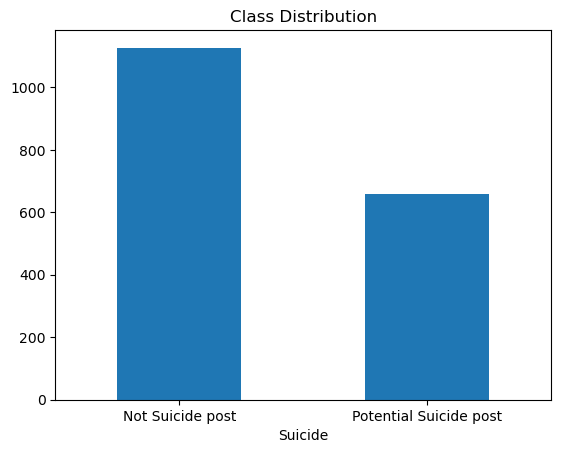

In [12]:
# Class distribution
df['Suicide'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xticks(rotation=0)

Text(0.5, 0, 'Length')

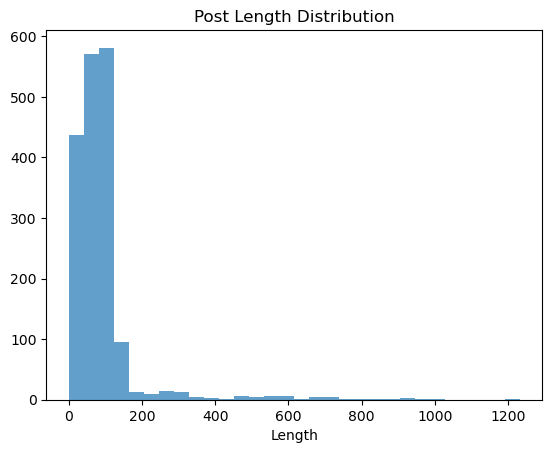

In [13]:
df['post_length'] = df['Tweet'].str.len()
plt.hist(df['post_length'], bins=30, alpha=0.7)
plt.title('Post Length Distribution')
plt.xlabel('Length')

Text(0.5, 1.0, 'Potential Suicide Tweets WordCloud')

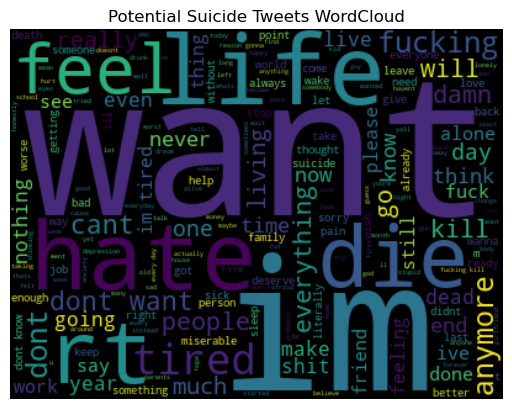

In [14]:
suicide_text = ' '.join(df[df['label']==1]['Tweet'])
wordcloud_suicide = WordCloud(width=400, height=300, background_color='black').generate(suicide_text)
plt.imshow(wordcloud_suicide, interpolation='bilinear')
plt.axis('off')
plt.title('Potential Suicide Tweets WordCloud')

Text(0.5, 1.0, 'Non-Suicide Tweets WordCloud')

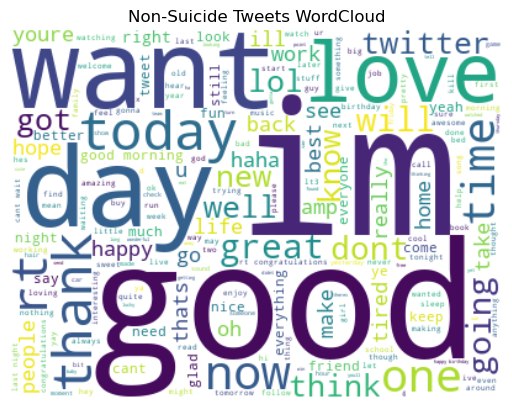

In [15]:
non_suicide_text = ' '.join(df[df['label']==0]['Tweet'])
wordcloud_non = WordCloud(width=400, height=300, background_color='white').generate(non_suicide_text)
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Suicide Tweets WordCloud')

## 3. FEATURE ENGINEERING

In [16]:
def extract_linguistic_features(text):
    """Extract advanced linguistic features"""
    words = word_tokenize(text.lower())
    
    # First person pronoun counts
    i_count = sum(1 for word in words if word in FIRST_PERSON_SINGULAR)
    we_count = sum(1 for word in words if word in FIRST_PERSON_PLURAL)
    pronoun_ratio = i_count / (we_count + 1)  # Avoid division by zero
    
    # Absolutist words
    absolutist_count = sum(1 for word in words if word in ABSOLUTIST_WORDS)
    
    # Readability score
    readability = textstat.flesch_reading_ease(text) if len(text) > 10 else 0
    
    # Post length
    length = len(text)
    
    return [pronoun_ratio, absolutist_count, readability, length]

In [17]:
def create_features(df):
    """Create TF-IDF + linguistic features"""
    # TF-IDF features
    tfidf = TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1,2))
    tfidf_matrix = tfidf.fit_transform(df['Tweet']).toarray()
    
    # Linguistic features
    linguistic_features = np.array(df['Tweet'].apply(extract_linguistic_features).tolist())
    
    # Combine features
    X = np.hstack([tfidf_matrix, linguistic_features])
    y = df['label'].values
    
    feature_names = list(tfidf.get_feature_names_out()) + ['pronoun_ratio', 'absolutist_count', 'readability', 'post_length']
    
    print(f"Final feature matrix shape: {X.shape}")
    print("Features include: TF-IDF (2000) + 4 linguistic features")
    
    return X, y, feature_names, tfidf

In [18]:
X, y, feature_names, tfidf_vectorizer = create_features(df)

Final feature matrix shape: (1787, 2004)
Features include: TF-IDF (2000) + 4 linguistic features


In [19]:
X

array([[  0.    ,   0.    ,   0.    , ...,   0.    ,  90.99  ,  17.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,  97.025 ,  19.    ],
       [  0.    ,   0.    ,   0.    , ...,   1.    ,  86.4225,  72.    ],
       ...,
       [  0.    ,   0.    ,   0.    , ...,   0.    ,  91.78  ,  51.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,  88.905 , 123.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,  61.2675,  60.    ]])

In [20]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [21]:
tfidf_vectorizer

TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english')

## 4. TRAIN-TEST SPLIT WITH STRATIFICATION

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. MODEL TRAINING & EVALUATION

In [23]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}


In [24]:
lr=LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
lr_y_pred_prob = lr.predict_proba(X_test)[:, 1]
lr_auc_score = roc_auc_score(y_test, lr_y_pred_prob)
print(f"\n=== Logistic Regression Results ===")
print(classification_report(y_test, lr_y_pred, target_names=['Non-Suicide', 'Suicide']))
print(f"ROC-AUC Score: {lr_auc_score:.4f}")


=== Logistic Regression Results ===
              precision    recall  f1-score   support

 Non-Suicide       0.90      0.97      0.93       226
     Suicide       0.94      0.82      0.87       132

    accuracy                           0.91       358
   macro avg       0.92      0.89      0.90       358
weighted avg       0.92      0.91      0.91       358

ROC-AUC Score: 0.9551


In [25]:
rf=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
rf_y_pred_prob = rf.predict_proba(X_test)[:, 1]
rf_auc_score = roc_auc_score(y_test, rf_y_pred_prob)
print("\n=== Random Forest Results ===")
print(classification_report(y_test, rf_y_pred, target_names=['Non-Suicide', 'Suicide']))
print(f"ROC-AUC Score: {rf_auc_score:.4f}")


=== Random Forest Results ===
              precision    recall  f1-score   support

 Non-Suicide       0.91      0.97      0.94       226
     Suicide       0.95      0.83      0.89       132

    accuracy                           0.92       358
   macro avg       0.93      0.90      0.91       358
weighted avg       0.92      0.92      0.92       358

ROC-AUC Score: 0.9705


Text(0.5, 23.52222222222222, 'Predicted Label')

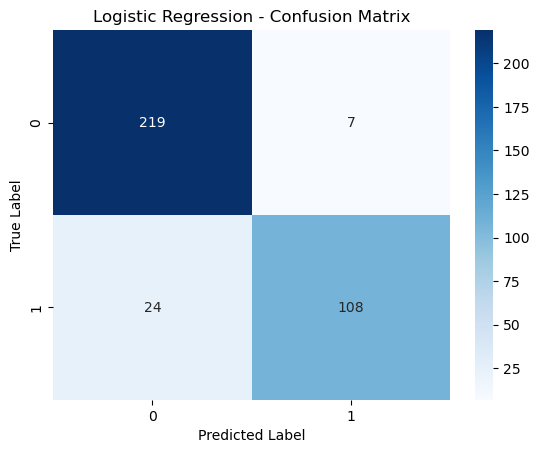

In [26]:
cm_lr = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

Text(0.5, 23.52222222222222, 'Predicted Label')

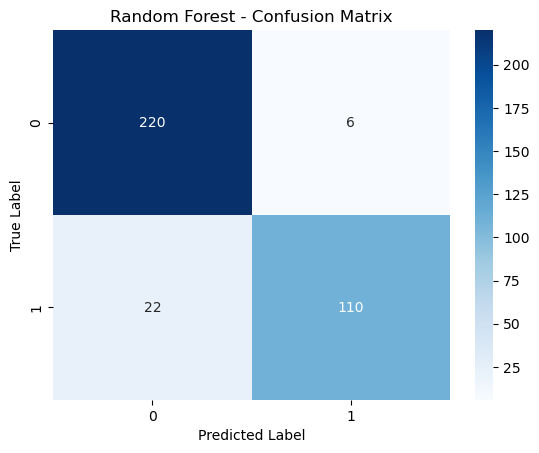

In [27]:
cm_rf = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

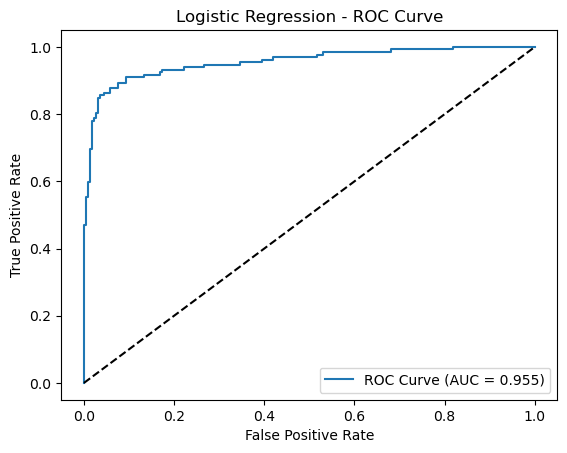

In [28]:
fpr, tpr, _ = roc_curve(y_test, lr_y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {lr_auc_score:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend()

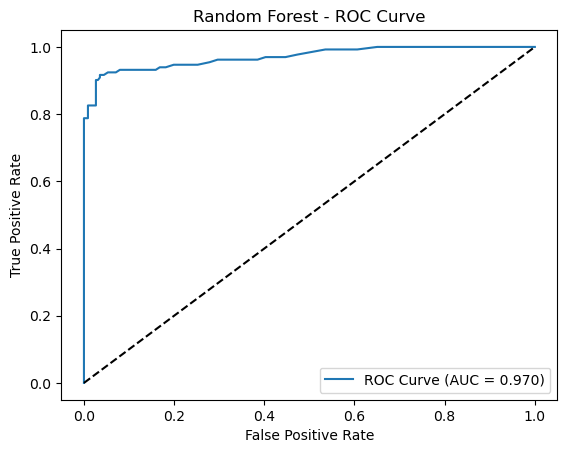

In [29]:
fpr, tpr, _ = roc_curve(y_test, rf_y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {rf_auc_score:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curve')
plt.legend()

In [30]:
print("Selected Model: Random Forest")
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_y_pred_prob):.4f}")

Selected Model: Random Forest
ROC-AUC Score: 0.9705


## 6. INFERENCE FUNCTION

In [31]:
def predict_suicide_risk(text, model=rf, tfidf=tfidf_vectorizer):
    """
    Predict suicide risk probability for new text
    Returns: probability score (0-1) where higher = higher risk
    """
    # Clean text
    cleaned_text = clean_text(text)
    
    # Extract features
    tfidf_features = tfidf.transform([cleaned_text]).toarray()
    linguistic_features = np.array([extract_linguistic_features(cleaned_text)])
    X_new = np.hstack([tfidf_features, linguistic_features])
    
    # Predict probability
    prob = model.predict_proba(X_new)[0, 1]
    
    risk_level = "LOW" if prob < 0.2 else "MEDIUM" if prob < 0.6 else "HIGH"
    
    print(f"Text: {text}")
    print(f"Cleaned: {cleaned_text}")
    print(f"Suicide Risk Probability: {prob:.3f} ({risk_level} RISK)")
    print(f"*** THIS IS A SCREENING TOOL ONLY ***")
    print("If you're in crisis, please contact:")
    print("- India: AASRA Helpline (91-9820466726)")
    print("- USA: 988 Suicide & Crisis Lifeline")
    print("- International: findahelpline.com")
    
    return prob

In [32]:
# test_texts = [
#     "i cant take this anymore nobody cares about me i just want to disappear forever",
#     "having a great day enjoying life with my friends and family",
#     "feeling really down lately nothing ever works out for me"
# ]

# print("\n=== INFERENCE EXAMPLES ===")
# for text in test_texts:
#     predict_suicide_risk(text)
predict_suicide_risk("having a great day enjoying life with my friends and family")

Text: having a great day enjoying life with my friends and family
Cleaned: having a great day enjoying life with my friends and family
Suicide Risk Probability: 0.190 (LOW RISK)
*** THIS IS A SCREENING TOOL ONLY ***
If you're in crisis, please contact:
- India: AASRA Helpline (91-9820466726)
- USA: 988 Suicide & Crisis Lifeline
- International: findahelpline.com


0.19

In [33]:
predict_suicide_risk("feeling really down lately nothing ever works out for me")

Text: feeling really down lately nothing ever works out for me
Cleaned: feeling really down lately nothing ever works out for me
Suicide Risk Probability: 0.230 (MEDIUM RISK)
*** THIS IS A SCREENING TOOL ONLY ***
If you're in crisis, please contact:
- India: AASRA Helpline (91-9820466726)
- USA: 988 Suicide & Crisis Lifeline
- International: findahelpline.com


0.23

In [34]:
predict_suicide_risk("i'm going to die")

Text: i'm going to die
Cleaned: im going to die
Suicide Risk Probability: 0.640 (HIGH RISK)
*** THIS IS A SCREENING TOOL ONLY ***
If you're in crisis, please contact:
- India: AASRA Helpline (91-9820466726)
- USA: 988 Suicide & Crisis Lifeline
- International: findahelpline.com


0.64

## 6. Creating small chatbot from this model with the help of some other files

In [35]:
def preprocess_input(text):
    return vectorizer.transform([text])

In [36]:
def stress_management():
    # List of stress management activities
    activities = [
        "Try some deep breathing exercises. They can help calm your mind and reduce stress.",
        "Take a short walk outside to get some fresh air and clear your mind.",
        "Engage in a hobby you enjoy, such as reading, painting, or playing music.",
        "Practice mindfulness or meditation to help center yourself.",
        "Take a break and do some stretching or light exercise to relieve tension."
    ]

    # List of helpful websites for stress management
    websites = [
        "https://www.calm.com/ - A website offering meditation and relaxation exercises.",
        "https://www.headspace.com/ - Provides guided meditation and mindfulness practices.",
        "https://www.moodfitapp.com/ - An app for tracking mood and managing stress.",
        "https://www.mentalhealth.gov/ - Offers resources and information on mental health.",
        "https://www.psychologytoday.com/ - Provides articles and therapy resources for stress management."
    ]

    # Combining activities and websites into a single response
    response = "Here are some activities you might find helpful for managing stress:\n"
    response += "\n".join(f"- {activity}" for activity in activities) + "\n\n"
    response += "You can also check out these websites for more resources:\n"
    response += "\n".join(f"- {website}" for website in websites)

    return response

In [37]:
games = ["Trivia Quiz", "Puzzle Challenge", "Word Search", "Riddles", "Guess the Word"]
# Define game functions
def trivia_quiz():
    questions = [
        {"question": "Who wrote 'To Kill a Mockingbird'?", "answer": "harper lee"},
        {"question": "What is the capital of France?", "answer": "paris"},
        {"question": "Which planet is known as the Red Planet?", "answer": "mars"}
    ]
    question = random.choice(questions)
    print(f"Trivia Question: {question['question']}")
    user_answer = input("Your answer: ").strip().lower()
    if user_answer == question['answer']:
        print("Correct!")
    else:
        print(f"Incorrect. The correct answer is {question['answer']}.")

import random

def puzzle_challenge():
    # List of puzzles with their answers
    puzzles = [
        {"puzzle": "tinsel", "answer": "silent"},
        {"puzzle": "teacup", "answer": "capture"},
        {"puzzle": "tar", "answer": "art"},
        {"puzzle": "bake", "answer": "beak"},
        {"puzzle": "drawer", "answer": "reward"},
        {"puzzle": "hints", "answer": "stinh"}
    ]

    # Randomly select a puzzle
    selected_puzzle = random.choice(puzzles)
    puzzle = selected_puzzle["puzzle"]
    answer = selected_puzzle["answer"]

    # Print the puzzle and get the user's answer
    print(f"Unscramble the letters to form a word: '{puzzle}'")
    user_answer = input("Your answer: ").strip().lower()

    # Check if the user's answer is correct
    if user_answer == answer:
        print("Correct!")
    else:
        print(f"Incorrect. The correct answer is {answer}.")


def word_search():
    words = ["python", "chatbot", "machine", "learning"]
    print("Find the following words in the grid: " + ", ".join(words))
    print("Here's a grid with the words hidden:")
    grid = [
        ["p", "y", "t", "h", "o", "n"],
        ["a", "b", "c", "h", "a", "t"],
        ["m", "a", "c", "h", "i", "n"],
        ["c", "h", "a", "t", "b", "o"],
        ["h", "t", "i", "n", "g", "e"],
        ["b", "i", "r", "d", "l", "e"]
          ]
    for row in grid:
        print(" ".join(row))
    input("Press Enter when you have found the words...")

def riddles():
    riddles = [
        {"riddle": "I speak without a mouth and hear without ears. I have no body, but I come alive with wind. What am I?", "answer": "echo"},
        {"riddle": "The more you take, the more you leave behind. What am I?", "answer": "footsteps"},
        {"riddle": "I have cities, but no houses. I have mountains, but no trees. I have water, but no fish. What am I?", "answer": "map"}
    ]
    riddle = random.choice(riddles)
    print(f"Riddle: {riddle['riddle']}")
    user_answer = input("Your answer: ").strip().lower()
    if user_answer == riddle['answer']:
        print("Correct!")
    else:
        print(f"Incorrect. The correct answer is {riddle['answer']}.")

def guess_the_word():
    words = ["python", "chatbot", "machine", "learning"]
    word = random.choice(words)
    print("Guess the word. It has", len(word), "letters.")
    attempts = 5
    while attempts > 0:
        guess = input("Your guess: ").strip().lower()
        if guess == word:
            print("Correct! The word was", word)
            return
        else:
            attempts -= 1
            print("Incorrect. Try again. Remaining attempts:", attempts)
    print(f"Out of attempts! The correct word was {word}.")


websites = [
    "https://www.nationalgeographic.com",
    "https://www.calm.com/",
    "https://www.rainymood.com/",
    "https://make-everything-ok.com/",
    "https://xhalr.com/",
    "https://www.pixelthoughts.co/",
    "https://my.happify.com/",
    "https://www.750words.com/",
    "https://simplynoise.com/https://simplynoise.com/",
    "https://explore.org/livecams",
    "https://play.playster.com/",
    "http://catsoundboard.com/"
]

def recommend_website():
    return "This is a great fun website.Check out this " + random.choice(websites)

In [43]:
import csv
import json
import re
import random
import joblib

# Load intents and models from files
file_path = "intents.json"
with open(file_path, 'r') as file:
    data = json.load(file)

def load_keywords(file_path):
    keywords = {}
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            if len(row) >= 2:
                keyword, response = row[0].strip(), row[1].strip()
                keywords[keyword.lower()] = response
    return keywords
#File  for some keyword matches
keywords = load_keywords("keywords.csv")
# Define global variables
context = None
last_game = None

def preprocess_input(user_input):
    user_input = user_input.lower()
    user_input = re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', user_input)).strip()
    return user_input

# Assuming your trained vectorizer is named 'tfidf' in your notebook
def detect_suicide(user_input):
    cleaned_text = clean_text(user_input)

    # TF-IDF features
    tfidf_features = tfidf.transform([cleaned_text]).toarray()

    # Linguistic features (same 4 as training)
    linguistic_features = np.array(
        [extract_linguistic_features(cleaned_text)]
    )

    # Combine exactly like training
    input_vector = np.hstack([tfidf_features, linguistic_features])

    prediction = rf.predict(input_vector)
    return prediction[0] == 1

def match_intent(user_input, intents):
    for intent in intents:
        matched = False
        for pattern in intent['patterns']:
            if pattern:  # Skip empty patterns
                if re.search(pattern, user_input, re.IGNORECASE):
                    matched = True
                    break
        if matched:
            return random.choice(intent['responses'])  
    return None

def match_keyword(user_input, keywords):

    
    sorted_keywords = sorted(keywords.keys(), key=len, reverse=True)

    for keyword in sorted_keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', user_input, re.IGNORECASE):
            return keywords[keyword]

    
    for keyword in sorted_keywords:
        if keyword in user_input.lower(): 
            return keywords[keyword]

    return None



def get_response(user_input):
    global context, last_game


    
    if detect_suicide(user_input):
        return ("I'm really sorry you're feeling this way, but I'm not equipped to help. Please reach out to someone who can provide the support you need. "
                "It's important to talk to a mental health professional or someone you trust. Please contact the National Suicide Prevention Lifeline at 1800-5990019, or reach out to a local emergency service.")

    preprocessed_input = preprocess_input(user_input)

    recommend_keywords = [
        "recommend", "suggest", "website", "site", "link", "resource", "where to go", "what to check out", "show me a website"
    ]

   
    if any(keyword in preprocessed_input for keyword in recommend_keywords):
        return recommend_website()

    stress_keywords = [
        "stress", "anxious", "nervous", "overwhelmed", "worried", "tense", "burnout"
    ]
    if any(keyword in preprocessed_input for keyword in stress_keywords):
        return stress_management()


    if "gameplay" in user_input.lower():
        context = "game"
        last_game = random.choice(["Trivia Quiz", "Puzzle Challenge", "Word Search", "Riddles", "Guess the Word"])
        print(f"Selected Game: {last_game}")
        if last_game == "Trivia Quiz":
            return trivia_quiz()
        elif last_game == "Puzzle Challenge":
            return puzzle_challenge()
        elif last_game == "Word Search":
            return word_search()
        elif last_game == "Riddles":
            return riddles()
        elif last_game == "Guess the Word":
            return guess_the_word()

    if context == "game" and user_input.lower() == "yes":
        print(f"Context is Game. Last Game: {last_game}")
        if last_game == "Trivia Quiz":
            return trivia_quiz()
        elif last_game == "Puzzle Challenge":
            return puzzle_challenge()
        elif last_game == "Word Search":
            return word_search()
        elif last_game == "Riddles":
            return riddles()
        elif last_game == "Guess the Word":
            return guess_the_word()

    # Checking for intent match
    response = match_intent(preprocessed_input, data['intents'])
    if response:
        return response
# Checking for keyword match
    response = match_keyword(preprocessed_input, keywords)
    if response:
        return response

    # Default response if no matches found
    return "Sorry, I didn't understand that."

In [44]:
test_inputs = [
    "I am sad",
    "I want to die",
    "Hello there",
    "angry"
]

for test_input in test_inputs:
    print(f"User Input: {test_input}")
    print(f"Response: {get_response(test_input)}\n")

User Input: I am sad
Response: I'm here for you. Could you tell me why you're feeling this way?

User Input: I want to die
Response: I'm really sorry you're feeling this way, but I'm not equipped to help. Please reach out to someone who can provide the support you need. It's important to talk to a mental health professional or someone you trust. Please contact the National Suicide Prevention Lifeline at 1800-5990019, or reach out to a local emergency service.

User Input: Hello there
Response: Great to see you. How do you feel currently?

User Input: angry
Response: Forgive me if I did anything to offend you. I only want to help.



In [ ]:
X, y, feature_names, tfidf = create_features(df)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X, y)

In [40]:
# A small console chatbot
def run_chatbot():
    print("Chatbot: Hello! I'm here to help you. How can I assist you. I can play game and can recommend you website too. Write 'gameplay' to play game. Lets's begin our talk :D")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Chatbot: Goodbye! Take care!")
            break
        response = get_response(user_input)
        print(f"Chatbot: {response}")

# Start the chatbot
run_chatbot()

Chatbot: Hello! I'm here to help you. How can I assist you. I can play game and can recommend you website too. Write 'gameplay' to play game. Lets's begin our talk :D


You:  hello


NameError: name 'tfidf' is not defined